# ⏰ 시계열 데이터 분석 (Time Series Analysis) 1차시 과제

> **시계열 데이터** : 시간의 흐름에 따라 관측되어 수집된 통계량으로 시간의 영향을 받는 데이터.

## 1. 시계열 기초

#### 시계열 데이터의 특징

- **시간의존성 (Temporal Dependence)** : 데이터는 시간에 따라 변화한다.
- **자기상관성 (Autocorrelation)** : 이전 시점의 값이 이후 시점의 값에 영향을 미친다.
- **계절성 (Seasonality) & 추세 (Trend)** : 시간에 따라 장기적으로 증가/감소하는 추세 + 일정 주기로 반복되는 패턴.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import platform

# 운영체제에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # Windows 전용 폰트
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')  # macOS 전용 폰트
else:
    plt.rc('font', family='NanumGothic')  # 리눅스 또는 기타 환경
plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

`Day` 컬럼을 인덱스로 csv 파일을 읽어옵니다.

In [ ]:
df = pd.read_csv('tunnel.csv', index_col='Day', parse_dates=['Day'])

df.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


x축을 시간으로 하여 시간의 흐름 순으로 그래프를 그릴 수 있습니다.

<Axes: xlabel='Day'>

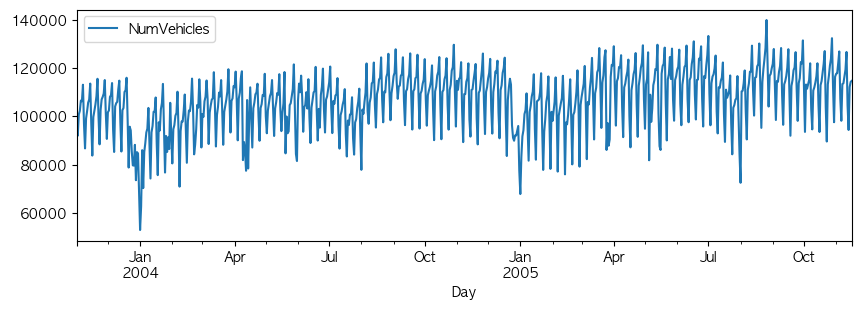

In [3]:
df.plot(figsize=(10, 3))

## 2. 시계열 그래프 요소 분해

> **요소분해** : 주어진 시계열 데이터를 개별 성분(추세성, 계절성, 순환성, 불규칙성)으로 분해하는 과정

실습에서와 달리 이번에는 statsmodels의 `STL` 객체를 활용해보겠습니다. `STL` 객체를 이용하면 시계열 데이터를 계절성(Seasonal), 추세(Trend), 잔차(Residual; 설명되지 않는 나머지)로 분해해볼 수 있습니다 !

---

**Q.** `STL`은 기본적으로 가법 모형(Additive Model)을 기반으로 합니다. 승법 모형에 적용하려면 어떻게 해야 할까요?

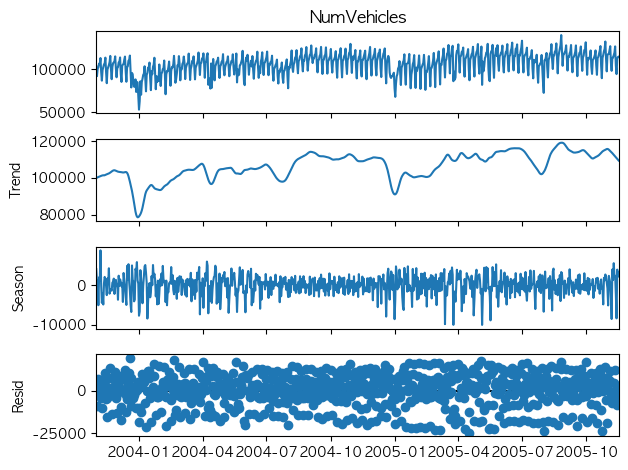

In [ ]:
from statsmodels.tsa.seasonal import STL

# STL 분해
stl = STL(df['NumVehicles'], period=12)  # period는 데이터의 계절성 주기 (예: 월별이면 12)
result = stl.fit()

result.plot()
plt.show()

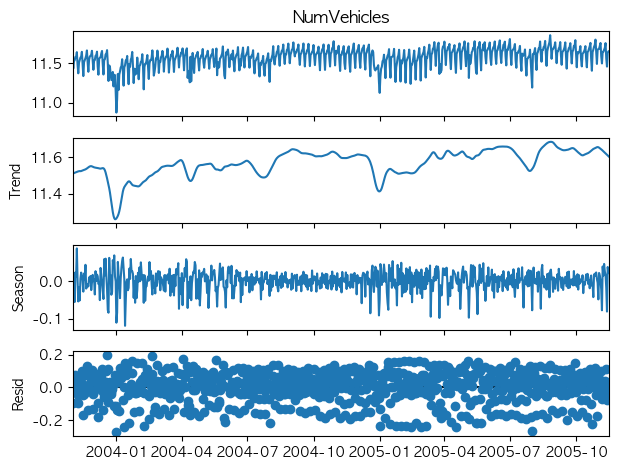

In [ ]:
# 승법 모형을 사용하고 싶다면 로그 변환 후 STL 분해를 진행하면 됩니다 !
stl = STL(np.log(df['NumVehicles']), period=12)
result = stl.fit() # fit() 메서드를 사용하여 STL 분해를 수행합니다.

result.plot()
plt.show()

## 3. 정상성 검정

### 3-1. ADF Test

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["NumVehicles"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Lags: {adf_result[2]}")
print(f"stationary: {adf_result[1] < 0.05}")

ADF Statistic: -2.280423048860848
p-value: 0.1783596813177613
Lags: 20
stationary: False


$\Rightarrow$ p-value 값이 0.05보다 크기 때문에, 비정상 시계열인 것을 확인할 수 있습니다 !

이어서 KPSS 테스트도 진행해 보겠습니다.

### 3-2. KPSS Test

In [7]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df["NumVehicles"])
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Lags: {kpss_result[2]}")

KPSS Statistic: 2.641020294550838
p-value: 0.01
Lags: 11


/var/folders/mx/nxjj2tz539x6hpt3jt6h10nw0000gn/T/ipykernel_76970/1416485730.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df["NumVehicles"])


#### **Q.** <span style="background: gold; color: black;">KPSS 검정의 결과를 해석해 보세요!</span>

*힌트.* KPSS 검정의 결과(p-value) 해석 방식은 ADF 검정의 결과 해석 방식과 조금 다릅니다. 어떤 차이가 있었죠?

- **답 :** p-value값이 0.05보다 작기 때문에 귀무가설을 기각,시계열은 비정상적이다

## 4. 정상성 확보 : 비정상 시계열을 정상 시계열로 변환하기

여러 가지 시계열 변환 방법들을 알아보겠습니다 !

In [8]:
# 정상성 검정 결과를 확인하기 편리하도록 함수를 정의하겠습니다.

def stationary_test(data):
    adf_result = adfuller(data)
    adf_p_value = round(adf_result[1], 4)
    kpss_result = kpss(data)
    kpss_p_value = round(kpss_result[1], 4)
    print(f"adf test p-value: {adf_p_value} ➡️ stationary: {adf_p_value < 0.05}")
    print(f"kpss test p-value: {kpss_p_value} ➡️ stationary: {kpss_p_value > 0.05}")

### 4-1. 차분

In [ ]:
df["1D_diff"] = df["NumVehicles"].diff()
df.head()

,NumVehicles,1D_diff
Day,,
2003-11-01,103536,NaN
2003-11-02,92051,-11485.0
2003-11-03,100795,8744.0
2003-11-04,102352,1557.0
2003-11-05,106569,4217.0


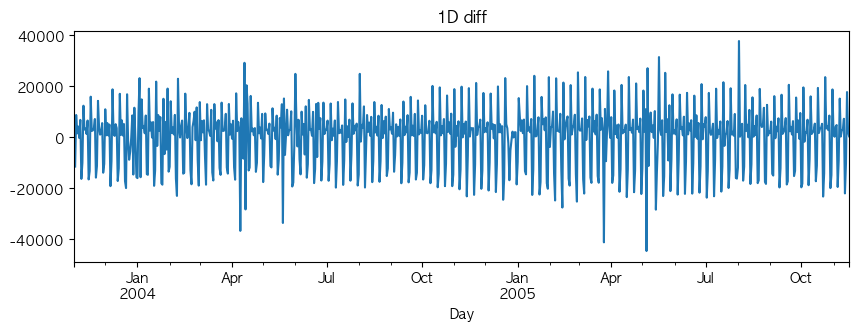

In [10]:
df["1D_diff"].plot(figsize=(10, 3), title="1D diff")
plt.show()

In [11]:
stationary_test(df["1D_diff"].dropna())

adf test p-value: 0.0 ➡️ stationary: True
kpss test p-value: 0.1 ➡️ stationary: True


/var/folders/mx/nxjj2tz539x6hpt3jt6h10nw0000gn/T/ipykernel_76970/1089682601.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data)


정상성이 충족된 것을 확인할 수 있습니다 !

### 4-2. 계절성 제거

<Axes: title={'center': 'Seasonal diff'}, xlabel='Day'>

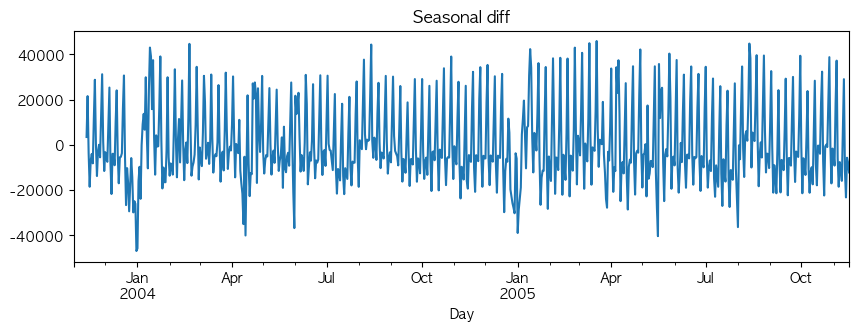

In [ ]:
# 계절 차분이라고도 부릅니다
df["seasonal_diff"] = df["NumVehicles"].diff(periods=12)
df["seasonal_diff"].plot(figsize=(10, 3), title="Seasonal diff")

In [13]:
stationary_test(df["seasonal_diff"].dropna())

adf test p-value: 0.0 ➡️ stationary: True
kpss test p-value: 0.1 ➡️ stationary: True


/var/folders/mx/nxjj2tz539x6hpt3jt6h10nw0000gn/T/ipykernel_76970/1089682601.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data)


### 4-3. 로그 변환

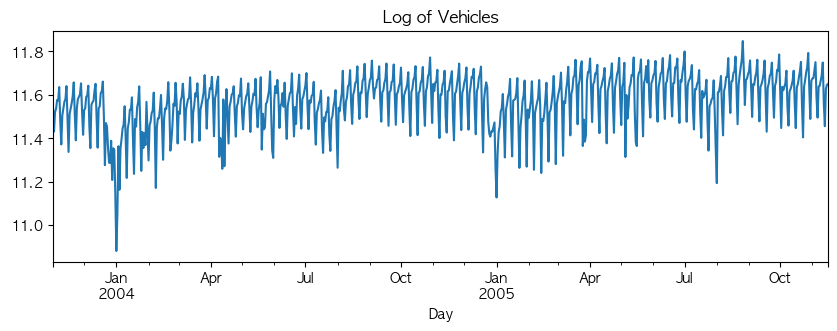

In [ ]:
df["log_vehicles"] = np.log(df["NumVehicles"]) # 로그 변환
df["log_vehicles"].plot(figsize=(10, 3), title="Log of Vehicles")
plt.show()

In [15]:
stationary_test(df["log_vehicles"].dropna())

adf test p-value: 0.1404 ➡️ stationary: False
kpss test p-value: 0.01 ➡️ stationary: False


/var/folders/mx/nxjj2tz539x6hpt3jt6h10nw0000gn/T/ipykernel_76970/1089682601.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data)


### 4-4. 추세 제거

<Axes: xlabel='Day'>

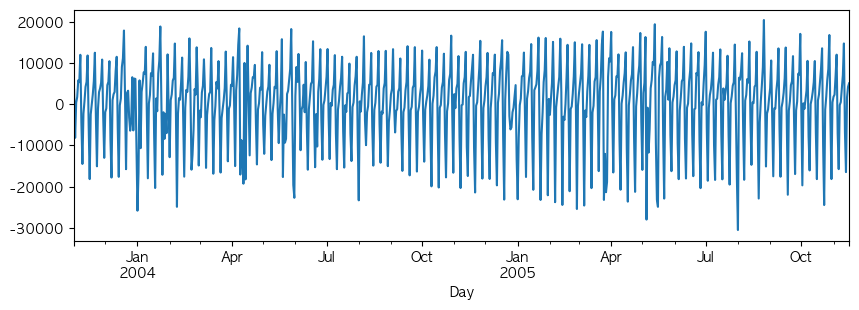

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(df["NumVehicles"], period=12)
result = stl.fit()
df["detrended"] = df["NumVehicles"] - result.trend

df["detrended"].plot(figsize=(10, 3))

In [17]:
stationary_test(df["detrended"].dropna())

adf test p-value: 0.0 ➡️ stationary: True
kpss test p-value: 0.1 ➡️ stationary: True


/var/folders/mx/nxjj2tz539x6hpt3jt6h10nw0000gn/T/ipykernel_76970/1089682601.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data)


## 5. 회귀 모델링

**시계열 데이터의 선형 회귀**

- 선형회귀 알고리즘은 목적 변수(y)를 가장 잘 설명하는 수식을 찾아내는 것이 목표입니다.
- 각 속성(feature) 별로 가중치를 곱하고, 가중치의 곱을 더해 예측값을 도출합니다.
- 예측값과 실제값의 차이가 최소가 되는 가중치를 찾아내는 것이 목표!

각 시점의 이전 값(1-step lag)을 속성으로 사용하기 위해, 종속변수 컬럼의 값을 1만큼 shift하여 `lag` 컬럼을 생성합니다.

In [ ]:
# shift 메소드를 이용해 lag 변수를 추가할 수 있습니다 !
df['lag1'] = df["NumVehicles"].shift(1)

df.head(10)

,NumVehicles,1D_diff,seasonal_diff,log_vehicles,detrended,lag1
Day,,,,,,
2003-11-01,103536,NaN,NaN,11.547675,3553.185124,NaN
2003-11-02,92051,-11485.0,NaN,11.430098,-8129.477781,103536.0
2003-11-03,100795,8744.0,NaN,11.520844,433.731965,92051.0
2003-11-04,102352,1557.0,NaN,11.536173,1822.196185,100795.0
2003-11-05,106569,4217.0,NaN,11.576548,5876.676289,102352.0
2003-11-06,106284,-285.0,NaN,11.573870,5431.507645,106569.0
2003-11-07,113111,6827.0,NaN,11.636125,12099.904049,106284.0
2003-11-08,96806,-16305.0,NaN,11.480464,-4359.034830,113111.0
2003-11-09,86811,-9995.0,NaN,11.371489,-14495.120694,96806.0


In [ ]:
import statsmodels.api as sm

# 모델링을 위한 DataFrame 변환 
# 정상성 만족하도록 차분을 적용한 컬럼을 선택합니다.
df_model = pd.DataFrame({'y': df['1D_diff'].dropna()})

# 시차 변수 생성
for i in range(1, 4):
    df_model[f'lag{i}'] = df_model['y'].***(i) # lag 변수를 만들 때 어떤 함수를 적용했었죠?

# 결측값 제거
df_model.dropna(inplace=True)

# 데이터 분할
X = df_model[['lag1', 'lag2', 'lag3']]
X = sm.add_constant(X) # 상수항 추가
y = df_model['y']

# OLS 회귀 모델 학습
model = sm.OLS(y, X).fit()
df_model['pred'] = model.predict(X)


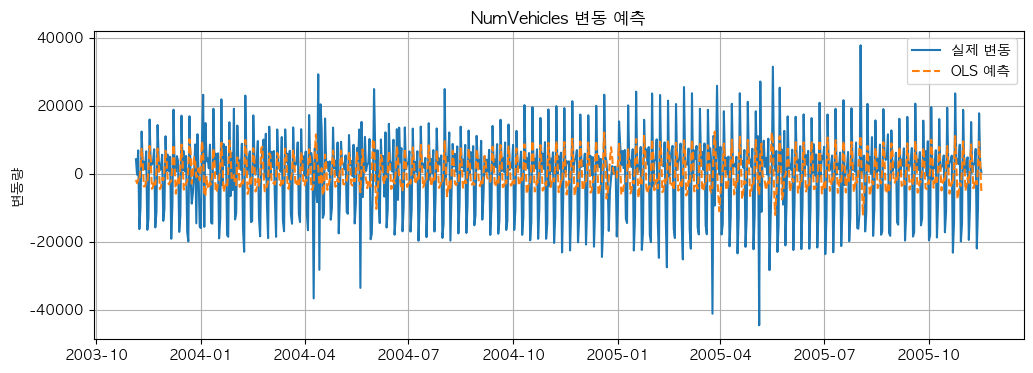

In [20]:
# 예측 시각화
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, y, label='실제 변동')
plt.plot(df_model.index, df_model['pred'], linestyle='--', label='OLS 예측')
plt.title('NumVehicles 변동 예측')
plt.ylabel('변동량')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 회귀 요약 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     44.43
Date:                Fri, 30 May 2025   Prob (F-statistic):           2.10e-26
Time:                        00:59:10   Log-Likelihood:                -7974.6
No. Observations:                 743   AIC:                         1.596e+04
Df Residuals:                     739   BIC:                         1.598e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9134    408.031      0.071      0.9